In [58]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm
from statsmodels.tsa import stattools

In [3]:
# load your dataset
data_dir = os.path.join(os.getcwd(), 'data_files')

target_df = pd.read_csv(os.path.join(data_dir, 'targets.csv'), parse_dates=['USAGE_DATE'], index_col='USAGE_DATE')
predictor_df = pd.read_csv(os.path.join(data_dir, 'predictors.csv'), parse_dates=['USAGE_DATE'], index_col='USAGE_DATE')
predictor_df['Holiday'] = predictor_df['Holiday'].astype(int)

df = target_df.join(predictor_df).sort_index(ascending=True)

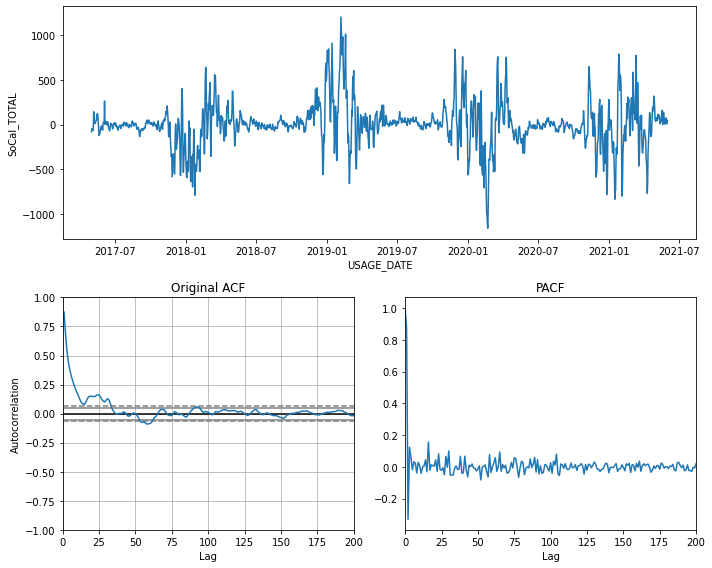

In [129]:
# identify whether target series is stationary by checking acf plot

def acf_plots(data):
    fig = plt.figure(figsize=(10, 8))
    gs = GridSpec(2, 2, figure=fig)
    ax1 = fig.add_subplot(gs[0, :])
    ax2 = fig.add_subplot(gs[1, 0])
    ax3 = fig.add_subplot(gs[1, 1])

    sns.lineplot(data=data, ax=ax1)

    pd.plotting.autocorrelation_plot(data, ax=ax2)
    ax2.set_title('Original ACF'), ax2.set_ylim([-1, 1]), ax2.set_xlim([0, 200])

    sns.lineplot(data=stattools.pacf(data, nlags=200), ax=ax3)
    ax3.set_title('PACF'), ax3.set_xlabel('Lag'), ax3.set_xlim([0, 200])

    plt.tight_layout(), plt.show()

# acf_plots(df['SoCal_TOTAL'])
seasonal_diff =df['SoCal_TOTAL'].diff(365).dropna()
acf_plots(seasonal_diff)

In [138]:
df_test = df[df.index >= pd.to_datetime('4/15/21')] 
df_train = df[df.index < pd.to_datetime('4/15/21')]
stepwise_fit = pm.auto_arima(df_train['SoCal_TOTAL'], start_p=1, max_p=10,
                             start_q=1, max_q=10, 
                             seasonal=True, D=1,
                            stepwise=True)
stepwise_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1810
Model:               SARIMAX(5, 1, 3)   Log Likelihood              -10540.552
Date:                Wed, 07 Jul 2021   AIC                          21099.103
Time:                        16:52:04   BIC                          21148.608
Sample:                             0   HQIC                         21117.373
                               - 1810                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5156      0.029    -17.754      0.000      -0.573      -0.459
ar.L2          0.4603      0.037     12.282      0.000       0.387       0.534
ar.L3          0.4454      0.030     14.900      0.000       0.387       0.504
ar.L4         -0.2759      0.022    -12.706      0.000      -0.319      -0.233
ar.L5          0.0819      0.019      4.275      0.000       0.044       0.119
ma.L1          0.7520      0.027     27.982      0.000       0.699       0.805
ma.L2         -0.4742      0.040    -11.980      0.000      -0.552      -0.397
ma.L3         -0.8500      0.027    -31.855      0.000      -0.902      -0.798
sigma2      6717.4336    102.921     65.268      0.000    6515.712    6919.155
===================================================================================
Ljung-Box (L1) (Q):                   0.11   Jarque-Bera (JB):              4935.73
Prob(Q):                              0.74   Prob(JB):                         0.00
Heteroskedasticity (H):               1.80   Skew:                             1.08
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.80
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

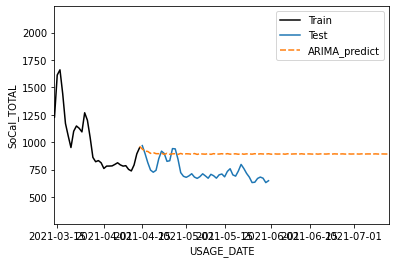

In [147]:
days_to_forecast = pd.date_range(start=df_train.index.max(), end = df_train.index.max() + pd.DateOffset(months=3), freq='1d')
predictions = pd.DataFrame({'ARIMA_predict': stepwise_fit.predict(len(days_to_forecast))})
predictions.index=days_to_forecast

compare_df = pd.concat([df_test['SoCal_TOTAL'], predictions], axis=1).rename(columns={'SoCal_TOTAL': 'Test'})
sns.lineplot(data=df_train['SoCal_TOTAL'], color='k', label='Train')
sns.lineplot(data=compare_df, )
plt.xlim([df_train.index.max() - pd.DateOffset(months=1), predictions.index.max()])
plt.show()

In [144]:
pd.date_range(start=df_train.index.max(), end = df_train.index.max() + pd.DateOffset(months=3), freq='1d')

DatetimeIndex(['2021-04-14', '2021-04-15', '2021-04-16', '2021-04-17',
               '2021-04-18', '2021-04-19', '2021-04-20', '2021-04-21',
               '2021-04-22', '2021-04-23', '2021-04-24', '2021-04-25',
               '2021-04-26', '2021-04-27', '2021-04-28', '2021-04-29',
               '2021-04-30', '2021-05-01', '2021-05-02', '2021-05-03',
               '2021-05-04', '2021-05-05', '2021-05-06', '2021-05-07',
               '2021-05-08', '2021-05-09', '2021-05-10', '2021-05-11',
               '2021-05-12', '2021-05-13', '2021-05-14', '2021-05-15',
               '2021-05-16', '2021-05-17', '2021-05-18', '2021-05-19',
               '2021-05-20', '2021-05-21', '2021-05-22', '2021-05-23',
               '2021-05-24', '2021-05-25', '2021-05-26', '2021-05-27',
               '2021-05-28', '2021-05-29', '2021-05-30', '2021-05-31',
               '2021-06-01', '2021-06-02', '2021-06-03', '2021-06-04',
               '2021-06-05', '2021-06-06', '2021-06-07', '2021-06-08',
      

In [ ]:
# transform target data to stationary

lb_test = sm.stats.acorr_ljungbox(df[forecast_column+'_residuals'], lags=[27])

df['SoCal_TOTAL']

In [ ]:
tmp = ARIMA(df['SoCal_TOTAL'].pct_change().dropna()).fit()
tmp.summary()

In [ ]:
def objfunc(order, exog, endog):
    fit = ARIMA(endog, order, exog).fit()
    return fit.aic()

from scipy.optimize import brute
grid = (slice(1, 3, 1), slice(1, 3, 1), slice(1, 3, 1))
brute(objfunc, grid, args=(exog, endog), finish=None)